# Anime recommender system 

In this notebook will cover the first part of building our RS which is **the preprocessing of the data** ...

Our RS is content based and collaborative filtering based .

* Content based -
    Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.
* Collaborative filtering - 
   CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).
   
we used different RS because we wanted to use differenet approaches inorder to recommended the same thing ...

## The data

The data that we are going to use is from [Anime Dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database)

### Data content

#### Anime.csv

* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".

#### Rating.csv

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).


#### The preprocessing is divided into two parts:
* the preprocessing of the anime.csv data for the CBRS and it is also used in the CFRS .
* the preprocessing of the rating.csv data so that it can be used in CRFS 


<h5>Additional libraries used in Content Based system</h5>

In [37]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np

<h5>Additional libraries used in Knn model</h5>

In [2]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

### 1-the preprocessing of the anime.csv file
As mentioned above the anime.csv file contains genre,type,rating and we will later use these in order to recommend anime based on it's gener and type which we will treat as equal and turn them into one hot encoded features for the cosine-smiliraty.<br>
we only used pandas to work dircetly with the data , the other libraries are just for the visualisation of the data ... 

In [3]:
# Importing required libraries.
import pandas as pd
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

#### Reading the Data
First we read the Anime.csv file using pandas read_csv which reads the comma separated values file .<br>
the function takes the the file path and then returns it as a [Data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) , which is pandas data strcture, and then we show the first five rows of the DF.

In [4]:
df = pd.read_csv('AnimeRS-Data/anime.csv')

df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


The data types in the dataset

In [5]:
df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

The shape of the dataframe

In [6]:
df.shape

(12294, 7)

before we see anything we need to first check and clean missing data so we don't face any errors .

In [7]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [8]:
(df["episodes"]=="Unknown").sum()

340

As we can see we have episodes for diffrenet types have values as **unknown** and we have more than **300 empty cells** in three diffrenet columns.<br>
let's fix that by first removing the rows that contain missing data in the genre and type columns 

In [9]:
df = df.loc[df['type'].notna()]
df = df.loc[df['genre'].notna()]

and now the cells with the empty rating will be replaced by the median rating in the column

In [10]:
madian = df["rating"].median() - 1
df["rating"].fillna(madian, inplace=True)

In [11]:
df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

All good :) , and now we replace the unknown with just the value 1

In [12]:
df.loc[(df["episodes"] == "Unknown"), "episodes"] = "1"

In [13]:
(df["episodes"]=="Unknown").sum()

0

We finished missing data cleaning and now we want to know what are the unique values in the type column 

In [14]:
df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

**The distributions**

This table shows the distributaion of genres.

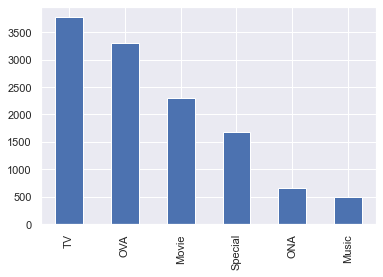

In [15]:
df['type'].value_counts().plot.bar()

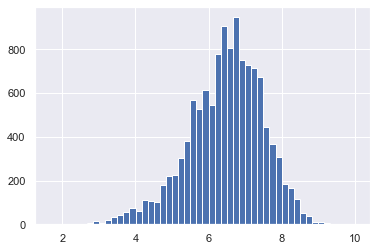

In [16]:
df['rating'].hist(bins=50)

From the two graphs we can interpret that the most anime types are tv and ova and most ratings are between ~5.5 -> ~8

In the anime names after we have made the code we have noticed that a lot of anime names need cleaning and we wanted them to be in lower case for easier finding

In [17]:
df['name'].head()

0                      Kimi no Na wa.
1    Fullmetal Alchemist: Brotherhood
2                            Gintama°
3                         Steins;Gate
4                       Gintama&#039;
Name: name, dtype: object

as shown above we can see that some have names that need cleaning

In [18]:
df["name"] = df["name"].str.replace('&#039;', '\'')
df["name"] = df["name"].str.replace('\'', '1')
df["name"] = df["name"].str.replace('[^\s\w]', '')
df["name"] = df["name"].str.lower()
## we reached these lines of code after lots of trial and error and optimizing the cleaning 
## so please take it as it is

In [19]:
df['name'].head()

0                      kimi no na wa
1    fullmetal alchemist brotherhood
2                            gintama
3                         steinsgate
4                           gintama1
Name: name, dtype: object

the dataset is cleaned ready to be worked with

In [20]:
df.to_csv('AnimeRS-Data/clean_anime.csv', index=False)

### Content based using cosine similraty
after we have cleaned the data and saved it for later use , we now continue preparing the df to be used for the our CBRS

In [21]:
clean_anime = pd.read_csv('AnimeRS-Data/clean_anime.csv') # loading the cleaned data

in order to calculate the cosine similarity  we first need to calculate the weighted averge and the idea is that, if you have very few votes for your particular movie, you don't put much trust on it, and lean instead towards a conservative estimate.
we used this formula:
![weighted rating](AnimeRS-Data/weighted-rating.png)<br>
and what we've done is we created the term which consists of the number of members / the quantile + the number of members 
and that for us a is some term and we multiplayed that with rating + the term multiplayed by the mean rating<br>

**number of members is how many people rated a specific anime**<br>
**the quantile is the member at 0.75 position in the normal distribution of the data**


In [22]:
def calc_quantile_mean(clean_anime):
    """
    :var quantile: takes the member at 0.75 position in the normal distribution of the data
    :var mean: calculates the average of the rating of each anime.
    """
    quantile = clean_anime.members.quantile(0.75)
    mean = clean_anime.rating.mean()
    return quantile, mean


def weighted_rating(clean_anime, quantile, mean):
    """
    :var term: gets the total users who rated each anime.
    """
    term = clean_anime['members'] / (quantile + clean_anime['members'])
    return clean_anime['rating'] * term + (1 - term) * mean

In [23]:
quantile, mean = calc_quantile_mean(clean_anime)
clean_anime['community_rating'] = clean_anime.apply(weighted_rating, axis=1, args=(quantile, mean))

In [24]:
clean_anime[['community_rating','rating']].head()

,community_rating,rating
0,9.238219,9.37
1,9.226824,9.26
2,9.035516,9.25
3,9.132247,9.17
4,9.000209,9.16


we now have the community rating wich is the weighted rating for each anime, and finally after we calculated that we can create a **one hot encoded vector** for each anime where each type and genre is equal and if the anime belongs to this genre or type it will have a value of 1 else 0

In [25]:
clean_anime.drop(['anime_id', 'rating', 'members', 'episodes'], axis=1, inplace=True) #we drop unwanted columns 

here we can see the datasplit between the genres in our dataset

![Genre Chart](AnimeRS-Data/genre-chart1.jpeg)

In the chart above we can see the disturbation of the genres and their frequencies
and because the cosine similarity needs a lot of values to compare to , so the less data there is the less compatible results we'll get.  

In [26]:
clean_anime = pd.concat(
    [clean_anime, clean_anime['type'].str.get_dummies(), clean_anime['genre'].str.get_dummies(sep=',')], axis=1)

In [27]:
clean_anime.head(10)

,name,genre,type,community_rating,Movie,Music,ONA,OVA,Special,TV,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,kimi no na wa,"Drama, Romance, School, Supernatural",Movie,9.238219,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fullmetal alchemist brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.226824,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.035516,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,steinsgate,"Sci-Fi, Thriller",TV,9.132247,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,gintama1,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.000209,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,haikyuu karasuno koukou vs shiratorizawa gakue...,"Comedy, Drama, School, Shounen, Sports",TV,8.901184,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,hunter x hunter 2011,"Action, Adventure, Shounen, Super Power",TV,9.071643,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,ginga eiyuu densetsu,"Drama, Military, Sci-Fi, Space",OVA,8.830457,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,gintama movie kanketsuhen yorozuya yo eien nare,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,8.793874,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,gintama1 enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,8.831784,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


As we can see now we have for each anime a vector of 176 different columns or **features**

In [28]:
#checking for duplicated columns
clean_anime.columns.duplicated()


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [29]:
# we now remove the duplicated columns
clean_anime = clean_anime.loc[:, ~clean_anime.columns.duplicated()]

In [30]:
clean_anime.columns

Index(['name', 'genre', 'type', 'community_rating', 'Movie', 'Music', 'ONA',
       'OVA', 'Special', 'TV', ' Adventure', ' Cars', ' Comedy', ' Dementia',
       ' Demons', ' Drama', ' Ecchi', ' Fantasy', ' Game', ' Harem', ' Hentai',
       ' Historical', ' Horror', ' Josei', ' Kids', ' Magic', ' Martial Arts',
       ' Mecha', ' Military', ' Music', ' Mystery', ' Parody', ' Police',
       ' Psychological', ' Romance', ' Samurai', ' School', ' Sci-Fi',
       ' Seinen', ' Shoujo', ' Shoujo Ai', ' Shounen', ' Shounen Ai',
       ' Slice of Life', ' Space', ' Sports', ' Super Power', ' Supernatural',
       ' Thriller', ' Vampire', ' Yaoi', ' Yuri', 'Action', 'Adventure',
       'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy',
       'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids',
       'Magic', 'Martial Arts', 'Mecha', 'Military', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', '

In [31]:
clean_anime.columns.shape

(91,)

and finally after we cleaned everthing we now prepare the feature vector for the cosine similarity

In [32]:
anime_features = clean_anime.loc[:, "Movie":].copy()

In [33]:
anime_features.head(6)

,Movie,Music,ONA,OVA,Special,TV,Adventure,Cars,Comedy,Dementia,...,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After that we have for each anime a one hot encoded feature vector for the consine similarity which will be shown now.

<h4>In our Content Based system we give a recomendation based on similarity of the features to the vector of the user's input.</h4> 

**note** results below.

In [44]:
def cosine_sim(anime_features):
    """
    calculating similarity for each anime with another anime.
    converting to float for easier calculation.
    """
#     anime_features_values = anime_features.values.astype(np.float32)
    return cosine_similarity(anime_features.values,anime_features.values)

<h4>We calculate the cosine similarity for each feature vector</h4>

In [45]:
cosine_sim_val = cosine_sim(anime_features)
cosine_sim_val

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31622777],
       [0.        , 1.        , 0.375     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.375     , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.31622777, 0.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ]])

In [47]:
cosine_sim_val.shape

(12210, 12210)

In [46]:
anime_index = pd.Series(clean_anime.index, index=clean_anime.name).drop_duplicates()
anime_index

name
kimi no na wa                                            0
fullmetal alchemist brotherhood                          1
gintama                                                  2
steinsgate                                               3
gintama1                                                 4
                                                     ...  
toushindai my lover minami tai mechaminami           12205
under world                                          12206
violence gekiga david no hoshi                       12207
violence gekiga shin david no hoshi inma densetsu    12208
yasuji no pornorama yacchimae                        12209
Length: 12210, dtype: int64

In [48]:
def get_recommendation(anime_name, cosine_sim, clean_anime, anime_index):
    """
    Getting pairwise similarity scores for all anime in the data frame.
    The function returns the top 10 most similar anime to the given query.
    """
    idx = anime_index[anime_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:11]
    anime_indices = [i[0] for i in sim_scores]
    result = clean_anime[['name']].iloc[anime_indices].drop(idx)
    return result

In the function above we take four paramaters:
<ul>
    <li>anime_name: the query of the user</li>
    <li>cosine_sim: a matrix of similarities</li>
    <li>clean_anime: table of each anime ,weighted rating and it's features  </li>
    <li>anime_index: the indices of all the animes in the dataset</li>
</ul>

by the name of the given anime we search for it's index in the anime_index matrix , after that we enumerate over the vector and make a list of the the similarities e.g: \[0.25,0.89,0.75,...\]
we then sort the sim_scores and take the top 10 animes and their indices and finally we access the location of the animes in the dataset

In our main project we take the usere's input from the consloe and adjust it to our preprocessed dataset


In [50]:
#results = get_recommendation(user_input.lower(), cosine_sim_val, clean_anime, anime_index)

In [51]:
results = get_recommendation('dragon ball z', cosine_sim_val, clean_anime, anime_index)

In [52]:
results

,name
515,dragon ball kai 2014
588,dragon ball kai
1930,dragon ball super
74,one piece
1409,dragon ball z movie 15 fukkatsu no f
3202,dragon ball z summer vacation special
4273,dragon ball z atsumare gokuu world
4312,dragon ball gt goku gaiden yuuki no akashi wa ...
5997,dragon ball z movie 11 super senshi gekiha kat...
615,naruto shippuuden


And as an anime fan I approve of these results because they are accurate 

### Collaborative filtering using KNN:
<h4>In our KNN model we give a recomendation based on similarity of the features to the vector of the user's input.</h4>

 * In this recommendation system, we will be using the collaborative filtering technique.
 * By using this technique, the system will recommend anime based on the nearest rating between the ratings of 
      user's anime and the ratings of other anime.
 * For example: if I watched 10 anime and gave each of them a some rating.And now, my friend watched an anime from my 
      anime list and he now asks me to recommend three animes. then, I will recommend three animes with the closest 
      rating to the rating I gave for the anime that my friend watched.
      
after we preprocessed for the CBRS we now do the same thing for this recommender system,
in this method we will use knn using cosine similarity so we will need the the rating.csv file and later for the knn model we also used clean_anime.csv file.<br>

**we first start by loading the rating.csv**<br>
the rating file contains the rating for each user per anime , if the user didn't rate an anime the rating will be -1

In [53]:
rating = pd.read_csv('AnimeRS-Data/rating.csv')

In [54]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [55]:
rating.shape

(7813737, 3)

In [56]:
rating.isnull().sum() # we have no null values so let's get started

user_id     0
anime_id    0
rating      0
dtype: int64

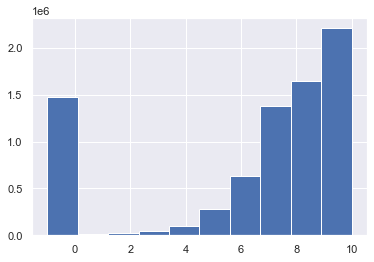

In [63]:
rating['rating'].hist(bins=10)

we can see that a lot of useres didn't vote for a lot of animes , but we can also see that there's a lot of rated animes with score of 6 and above

#### Remove animes with low count of ratings and users who gave low count of ratings
We will only consider popular anime (rating count over 250) and users who gave lots of rating on different anime (>100),
**but this is of coruse changeable**.

In [64]:
anime_ratings_count = rating.groupby(by='anime_id').count()['rating'].reset_index().rename(
    columns={'rating': 'rating_count'})

In [65]:
anime_ratings_count

,anime_id,rating_count
0,1,15509
1,5,6927
2,6,11077
3,7,2629
4,8,413
...,...,...
11195,34367,5
11196,34412,1
11197,34475,4
11198,34476,1


In [66]:
anime_ratings_count=anime_ratings_count[anime_ratings_count['rating_count'] > 250]

so after we grouped by the anime id we took only animes with ratings count above 250 so we can have less data and more accurate results

In [68]:
anime_ratings_count

,anime_id,rating_count
0,1,15509
1,5,6927
2,6,11077
3,7,2629
4,8,413
...,...,...
11078,33421,477
11097,33524,473
11112,33558,866
11181,34103,822


In [69]:
####now we do the same thing for the for the users
user_rating_count = rating.groupby(by='user_id').count()['rating'].reset_index().rename(
    columns={'rating': 'rating_count'})

In [70]:
user_rating_count

,user_id,rating_count
0,1,153
1,2,3
2,3,94
3,4,52
4,5,467
...,...,...
73510,73512,13
73511,73513,33
73512,73514,1
73513,73515,196


In [71]:
user_rating_count=user_rating_count[user_rating_count['rating_count'] > 100]

In [72]:
user_rating_count

,user_id,rating_count
0,1,153
4,5,467
6,7,343
10,11,112
12,13,174
...,...,...
73501,73503,246
73502,73504,106
73505,73507,259
73508,73510,135


In [75]:
def join_tables(filter_anime_rating, filter_user_rating, rating):
    filtered_rating_anime = rating[rating['anime_id'].isin(filter_anime_rating['anime_id'])]
    filtered_rating = filtered_rating_anime[filtered_rating_anime['user_id'].isin(filter_user_rating['user_id'])]
    return filtered_rating

<h4>creating a joined table using the three data frames</h4>

In [76]:
joined_table = join_tables(anime_ratings_count, user_rating_count, rating)

In [77]:
joined_table

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813730,73515,13659,8
7813731,73515,14345,7
7813732,73515,16512,7
7813733,73515,17187,9


we now convert the table into a matrix for easier access to the data

In [78]:
from scipy.sparse import csr_matrix ## the csr matrix is used in order to save data
def convert_to_matrix(joined_table):
    """
    converting table to matrix for easier access to data.
    """
    rating_matrix = joined_table.pivot_table(index='anime_id', columns='user_id', values='rating').fillna(0)
    csr_rating_matrix = csr_matrix(rating_matrix.values)
    return rating_matrix, csr_rating_matrix

**csr_rating_matrix** is a form of matrix that contains nonzero values as apposed to the **ratings_matrix**.
The reasoning behind this decision is to overcome the sparsity problem.

In [79]:
rating_matrix, csr_rating_matrix = convert_to_matrix(joined_table)

In [81]:
rating_matrix

user_id,1,5,7,11,13,14,17,21,29,35,...,73494,73495,73499,73500,73502,73503,73504,73507,73510,73515
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,9.0,0.0,0.0,...,0.0,10.0,9.0,0.0,0.0,9.0,10.0,9.0,0.0,10.0
5,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,9.0,0.0,0.0,...,0.0,8.0,0.0,0.0,0.0,7.0,10.0,8.0,0.0,10.0
6,0.0,8.0,0.0,0.0,-1.0,0.0,7.0,0.0,0.0,0.0,...,9.0,-1.0,9.0,0.0,0.0,9.0,9.0,9.0,0.0,10.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,9.0,0.0,7.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33524,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
print(csr_rating_matrix)

  (0, 4)	-1.0
  (0, 7)	9.0
  (0, 12)	10.0
  (0, 14)	10.0
  (0, 15)	10.0
  (0, 16)	-1.0
  (0, 21)	10.0
  (0, 32)	9.0
  (0, 33)	10.0
  (0, 36)	10.0
  (0, 39)	9.0
  (0, 40)	8.0
  (0, 44)	7.0
  (0, 45)	8.0
  (0, 49)	10.0
  (0, 51)	8.0
  (0, 52)	10.0
  (0, 55)	8.0
  (0, 56)	9.0
  (0, 62)	10.0
  (0, 64)	9.0
  (0, 65)	-1.0
  (0, 67)	-1.0
  (0, 69)	7.0
  (0, 71)	-1.0
  :	:
  (3317, 24343)	9.0
  (3317, 24345)	-1.0
  (3317, 24359)	10.0
  (3317, 24383)	-1.0
  (3317, 24385)	10.0
  (3317, 24391)	8.0
  (3317, 24392)	-1.0
  (3317, 24403)	8.0
  (3317, 24423)	-1.0
  (3317, 24426)	8.0
  (3317, 24429)	8.0
  (3317, 24444)	-1.0
  (3317, 24450)	9.0
  (3317, 24459)	8.0
  (3317, 24468)	7.0
  (3317, 24469)	8.0
  (3317, 24471)	-1.0
  (3317, 24480)	9.0
  (3317, 24493)	-1.0
  (3317, 24541)	8.0
  (3317, 24546)	-1.0
  (3317, 24557)	8.0
  (3317, 24579)	10.0
  (3317, 24583)	8.0
  (3317, 24631)	9.0


**The compressed sparse row:** (CSR) represents a matrix M by three (one-dimensional) arrays, that respectively contain nonzero values(on the right), the extents of rows, and column indices(on the left).

<h4>before fitting the data into nearest neighbor model</h4>
    we first take the user input, secondly we check the index of this anime in the clean_anime.csv dataset and finally we take the whole row of the rating matrix which contains the rating per anime for all the useres

In [86]:
anime = pd.read_csv('AnimeRS-Data/clean_anime.csv')
user_anime = anime[anime['name'] == 'dragon ball z']
user_anime

,anime_id,name,genre,type,episodes,rating,members
206,813,dragon ball z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",TV,291,8.32,375662


In [87]:
user_anime_index = np.where(rating_matrix.index == int(user_anime['anime_id']))[0][0]
user_anime_index

565

In [91]:
user_anime_ratings = rating_matrix.iloc[user_anime_index]
user_anime_ratings

user_id
1        0.0
5        5.0
7        9.0
11       0.0
13       0.0
        ... 
73503    5.0
73504    0.0
73507    0.0
73510    8.0
73515    0.0
Name: 813, Length: 24676, dtype: float64

In [93]:
user_anime_ratings_reshaped = user_anime_ratings.values.reshape(1,-1)

In [94]:
user_anime_ratings_reshaped

array([[0., 5., 9., ..., 0., 8., 0.]])

In [108]:
user_anime_ratings_reshaped

(1, 24676)

<h4>Fitting the model</h4>

we build the model by using:

In [95]:
from sklearn.neighbors import NearestNeighbors

and our metric of chocie is non other than cosine similarity 

In [96]:
def KNN(csr_rating_matrix):
    knn_model = NearestNeighbors(metric='cosine')
    knn_model.fit(csr_rating_matrix)
    return knn_model

In [97]:
#we send the csr for the calculations 
model = KNN(csr_rating_matrix)
model

NearestNeighbors(metric='cosine')

In [98]:
#we want the 10 most popular animes , we wrote 11 because the rating of the anime itself is included
distances, indices = model.kneighbors(user_anime_ratings_reshaped, n_neighbors=11)

In [113]:
##The indices here are from the rating matrix and we need to find the index for each anime in the clean anime dataset
indices

array([[ 565,  182,  183,  914,   10,   95,  631,  934, 1543,  184, 1249]],
      dtype=int64)

In [114]:
#as you can see the one the one with lowest cosine similarity is the same anime witht the same index
(distances*100).astype(np.uint8)

array([[ 0, 19, 23, 45, 45, 49, 50, 50, 50, 51, 51]], dtype=uint8)

From the rating matrix we take the values of the first coloumn by the indices we got from the KNN model which are the anime id

In [116]:
rating_matrix.iloc[indices[0]]

user_id,1,5,7,11,13,14,17,21,29,35,...,73494,73495,73499,73500,73502,73503,73504,73507,73510,73515
anime_id,,,,,,,,,,,,,,,,,,,,,
813,0.0,5.0,9.0,0.0,0.0,0.0,0.0,8.0,7.0,0.0,...,0.0,8.0,10.0,0.0,0.0,5.0,0.0,0.0,8.0,0.0
223,0.0,6.0,9.0,0.0,0.0,0.0,0.0,7.0,10.0,0.0,...,0.0,7.0,8.0,0.0,0.0,5.0,0.0,0.0,8.0,0.0
225,0.0,1.0,7.0,0.0,0.0,0.0,0.0,6.0,4.0,0.0,...,0.0,0.0,8.0,0.0,0.0,6.0,0.0,0.0,8.0,0.0
1535,0.0,4.0,9.0,0.0,-1.0,0.0,10.0,10.0,10.0,-1.0,...,9.0,9.0,0.0,10.0,0.0,7.0,8.0,9.0,0.0,10.0
20,-1.0,6.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,...,10.0,7.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
121,0.0,0.0,8.0,7.0,0.0,0.0,6.0,0.0,8.0,0.0,...,8.0,8.0,8.0,7.0,0.0,0.0,9.0,9.0,0.0,8.0
901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
1575,0.0,0.0,9.0,0.0,0.0,0.0,8.0,9.0,0.0,0.0,...,10.0,10.0,8.0,10.0,10.0,7.0,10.0,0.0,0.0,10.0
5114,0.0,0.0,0.0,8.0,0.0,0.0,10.0,9.0,0.0,0.0,...,0.0,9.0,10.0,9.0,0.0,0.0,10.0,9.0,0.0,10.0


In [118]:
anime_ids = rating_matrix.iloc[indices[0]].index[1:]
anime_ids

Int64Index([223, 225, 1535, 20, 121, 901, 1575, 5114, 226, 2904], dtype='int64', name='anime_id')

And finally we take the anime ids and search for the names in the clean anime dataset and print them ...

In [119]:
nearest_neighbors = pd.DataFrame({'anime_id': anime_ids})
nearest_neighbors

,anime_id
0,223
1,225
2,1535
3,20
4,121
5,901
6,1575
7,5114
8,226
9,2904


In [139]:
top_10_reco = pd.merge(nearest_neighbors, anime,on='anime_id',how='left')
top_10_reco

,anime_id,name,genre,type,episodes,rating,members
0,223,dragon ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",TV,153,8.16,316102
1,225,dragon ball gt,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",TV,64,6.72,226625
2,1535,death note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
3,20,naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,121,fullmetal alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,51,8.33,600384
5,901,dragon ball z movie 08 moetsukiro nessen resse...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,1,7.62,65953
6,1575,code geass hangyaku no lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
7,5114,fullmetal alchemist brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
8,226,elfen lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13,7.85,623511
9,2904,code geass hangyaku no lelouch r2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888


In [140]:
top_10_reco['name']

0                                          dragon ball
1                                       dragon ball gt
2                                           death note
3                                               naruto
4                                  fullmetal alchemist
5    dragon ball z movie 08 moetsukiro nessen resse...
6                       code geass hangyaku no lelouch
7                      fullmetal alchemist brotherhood
8                                           elfen lied
9                    code geass hangyaku no lelouch r2
Name: name, dtype: object

0                                          dragon ball
1                                       dragon ball gt
2                                           death note
3                                               naruto
4                                  fullmetal alchemist
5    dragon ball z movie 08 moetsukiro nessen resse...
6                       code geass hangyaku no lelouch
7                      fullmetal alchemist brotherhood
8                                           elfen lied
9                    code geass hangyaku no lelouch r2
Name: name, dtype: object

That's it for the preprocessing of the rating data which will be used in part two for building the knn model along with the clean_anime.csv